In [1]:

from tqdm.notebook import tqdm
from keras.models import load_model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras.backend as K
from tqdm import tqdm
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import fpgrowth
import igraph
from igraph import Graph, EdgeSeq
from scipy.signal import savgol_filter


In [2]:
data=np.load("celles.npy",allow_pickle=True)

In [3]:
data=np.array(data)

### get the typical cell

In [4]:
max=1000
index=0
s=0.89
for i in range(len(data)):
    if (len(data[i]["SOH"])>max and np.array(data[i]["SOH"])[-1]<=s ):
        max=len(data[i]["SOH"])
        index=i
        s=np.array(data[i]["SOH"])[-1]
    

In [5]:
max

1072

In [6]:
index

5

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2962471527.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C0" (-> color=(0.12156862745098039, 0.4666666666666667, 0.7058823529411765, 1.0)). The keyword argument will take precedence.
  ax.plot(data[i]["SOH"],'C0', label='charge policy: '+data[i]["charge_policy"][0],color='green') # true soh (green)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2962471527.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C8" (-> color=(0.7372549019607844, 0.7411764705882353, 0.13333333333333333, 1.0)). The keyword argument will take precedence.
  ax.plot(data[j]["SOH"],'C8', label='charge policy: '+data[j]["charge_policy"][0],color='orange')
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2962471527.py:8: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "C6" (-> color=(0.8901960784313725,

Text(0, 0.5, 'SOH')

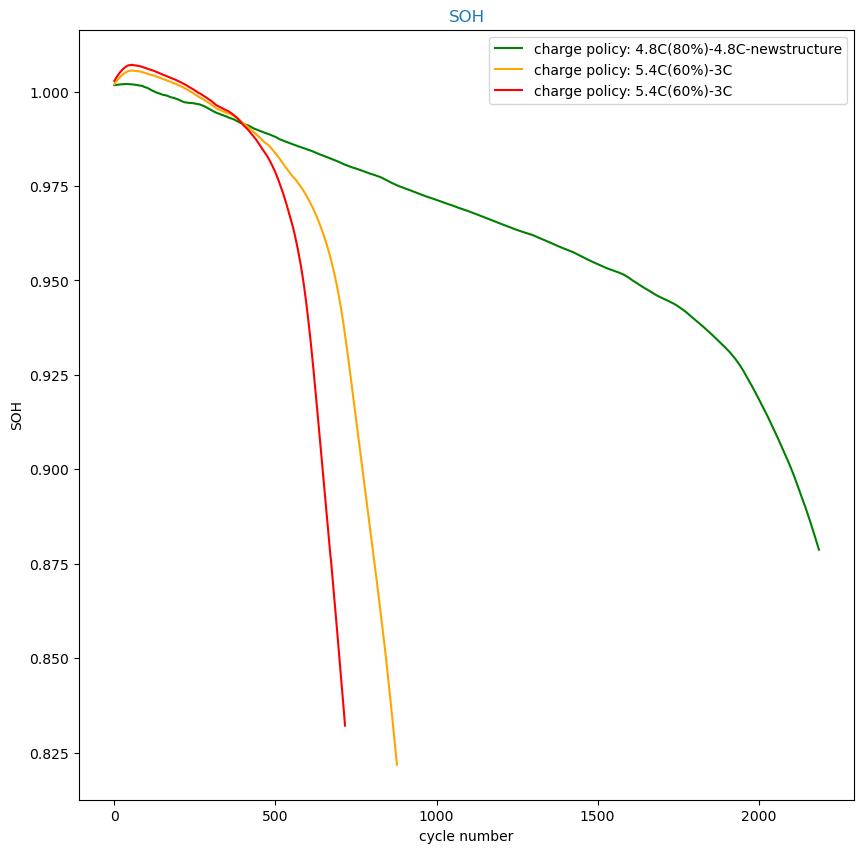

In [7]:
fig, ax = plt.subplots(figsize=(10, 10))
i=117
j=14
k=15
ax.set_title('SOH', color='C0')
ax.plot(data[i]["SOH"],'C0', label='charge policy: '+data[i]["charge_policy"][0],color='green') # typical soh (green)
ax.plot(data[j]["SOH"],'C8', label='charge policy: '+data[j]["charge_policy"][0],color='orange')
ax.plot(data[k]["SOH"],'C6', label='charge policy: '+data[k]["charge_policy"][0],color='red') 

ax.legend()
plt.xlabel("cycle number")
plt.ylabel("SOH")

In [9]:
input_step=10
output_step=10
model_cnn=load_model("combined_model_lstm_encoder_"+str(input_step)+".h5")

In [10]:
min_max=np.load("min_max.npy")

In [11]:
def normalization(x,min_max):
    import copy
    x1=copy.copy(x)
    t=np.zeros((len(x),6,500))
    for i in range(len(x1)):
        x1["Ic"][i]= (x1["Ic"][i]-min_max[0])/(min_max[1]-min_max[0])
        x1["Id"][i]= (x1["Id"][i]-min_max[2])/(min_max[3]-min_max[2])
        x1["Vc"][i]= (x1["Vc"][i]-min_max[4])/(min_max[5]-min_max[4])
        x1["Vd"][i]= (x1["Vd"][i]-min_max[6])/(min_max[7]-min_max[6])
        x1["Tc"][i]= (x1["Tc"][i]-min_max[8])/(min_max[9]-min_max[8])
        x1["Td"][i]= (x1["Td"][i]-min_max[10])/(min_max[11]-min_max[10])
        t[i][0][0:min(500,len(x["Ic"][i]))]=x1["Ic"][i][0:min(500,len(x1["Ic"][i]))]
        t[i][1][0:min(500,len(x["Id"][i]))]=x1["Id"][i][0:min(500,len(x1["Id"][i]))]
        
        t[i][2][0:min(500,len(x["Vc"][i]))]=x1["Vc"][i][0:min(500,len(x1["Vc"][i]))]
        t[i][3][0:min(500,len(x["Vd"][i]))]=x1["Vd"][i][0:min(500,len(x1["Vd"][i]))]
        
        t[i][4][0:min(500,len(x["Tc"][i]))]=x1["Tc"][i][0:min(500,len(x1["Tc"][i]))]
        t[i][5][0:min(500,len(x["Td"][i]))]=x1["Td"][i][0:min(500,len(x1["Td"][i]))]
    
    return t

In [12]:
def prepare_data(x):
    data=[]
    start=0
    end=input_step
    while (end<=len(x)):
            data.append(x[start:end])
            end=end+output_step
            start=start+output_step
    return data

In [13]:
def derive(data):
    d=[]
    for i in range(1,len(data),1):
        j=(data[i]-data[i-1])
        d.append(j)
    return d

In [14]:
def compare(data1,data2,soh1,soh2):
    size=min(len(data1),len(data2))
    t=abs(np.array(data1[0:size])-np.array(data2[0:size]))
    p=[]
    for i in range(len(t)):
        if(t[i]>=0.001):
            x=100-((soh2[i+1]*100)/soh1[i+1])
            p.append((i+1,data1[i],data2[i],soh1[i+1],soh2[i+1],x))
    return p
    

In [15]:
def select(d):
    p=[]
    for i in range(len(d)):
        if(d[i][5]>=1):
            p.append(d[i])
    return p

In [16]:
def events_extract(k,data):
    o=[]
    for j in range(len(k)):
            d=np.array(data[["Ic", "Id", "Vc", "Vd", "Tc", "Td","charge_policy"]][(k[j][0]-10):k[j][0]])
            if(len(d)!=0):
                o.append(d)
                o.append((k[j][0],k[j][5]))
            
    return o

In [17]:
def getEvents(data1,data2):
    dtrue_values=derive(data1["SOH"])
    dfalse_values=derive(data2["SOH"])
    p=compare(dtrue_values,dfalse_values,data1["SOH"],data2["SOH"])
    k=select(p)
    o=events_extract(k,data2)
    
    return o

In [18]:
class Data:
  def __init__(self,ic,id,vc,vd,tc,td):
    self.ic = ic
    self.vc = vc
    self.id = id
    self.vd = vd
    self.tc = tc
    self.td = td
    
    
  def __str__(self):
    return f"ic:{self.ic},id:{self.id},vc:{self.vc},vd:{self.vd},tc:{self.tc},td:{self.td}"

In [19]:
class Event:
   def __init__(self, data,time):
     self.data = data
     self.time = time
   def __str__(self):
    return f"(({self.data}),{self.time})"

In [20]:
class Chronicle:
    def __init__(self):
       self.event = []
    
    def addEvent(self, event):
       self.event.append(event)
    def plot(self):
        import networkx as nx
        G = nx.DiGraph()
        for i in range(len(self.event)):
            G.add_node(self.event[i].data)
            if(i+1<len(self.event)):
                G.add_edge(self.event[i].data, self.event[i+1].data, label="[0,"+str(self.event[i+1].time-self.event[i].time)+"]",arrows=True)

        # Draw the graph with edge labels
        pos = nx.spring_layout(G)
        nx.draw(G, pos, with_labels=True,node_color='#E1F4F9')
        edge_labels = nx.get_edge_attributes(G, 'label')
        nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels)
        plt.show()

In [21]:
def compare_graphs(d1,d2):
    size=min(len(d1),len(d2))
    corr = np.corrcoef(d1[0:size], d2[0:size])[0, 1]
    return corr>=0.93


In [22]:
def equal(d1,d2):
    return (d1[0]==d2[0] and d1[1]==d2[1] and  d1[2]==d2[2] and d1[3]==d2[3] and d1[4]==d2[4] and d1[5]==d2[5])

In [23]:
def createdf(data1,data2):
    events=getEvents(data1,data2)
    s=0
    datat=[]
    result=[]
    for i in range(0,len(events),2):
        data=[]
        s=(events[i+1][0])-10
        for j in range(len(events[i])):
            data.append((events[i][j],s))
            s=s+1
        result.append(events[i+1][1])
        datat.append(data)
    return datat,result

In [24]:
def getd(df_midum,ic,id,vc,vd,tc,td):
    Total_data_m=[]
    for i in range(len(df_midum)):
        data=[]
        for j in range(10):
            find=False
            for k in range(len(ic)):
                if(compare_graphs(ic[k][0],df_midum["data"][i][j][0][0]) and ic[k][1]==df_midum["data"][i][j][0][6] ):
                    IC="ic"+str(k)
                    find=True
                    break
            
            if(not find):
                ic.append((df_midum["data"][i][j][0][0],df_midum["data"][i][j][0][6]))
                IC="ic"+str(len(ic)+1)
            find=False
            for k in range(len(id)):
                if(compare_graphs(id[k][0],df_midum["data"][i][j][0][1]) and id[k][1]==df_midum["data"][i][j][0][6]):
                    ID="id"+str(k)
                    find=True
                    break
            if(not find):
                id.append((df_midum["data"][i][j][0][1],df_midum["data"][i][j][0][6]))
                ID="id"+str(len(id)+1)
            find=False
            for k in range(len(vc)):
                if(compare_graphs(vc[k][0],df_midum["data"][i][j][0][2]) and vc[k][1]==df_midum["data"][i][j][0][6]):
                    VC="vc"+str(k)
                    find=True
                    break
            if(not find):
                vc.append((df_midum["data"][i][j][0][2],df_midum["data"][i][j][0][6]))
                VC="vc"+str(len(vc)+1)
            find=False
            for k in range(len(vd)):
                if(compare_graphs(vd[k][0],df_midum["data"][i][j][0][3]) and vd[k][1]==df_midum["data"][i][j][0][6]):
                    VD="vd"+str(k)
                    find=True
                    break
            if( not find):
                vd.append((df_midum["data"][i][j][0][3],df_midum["data"][i][j][0][6]))
                VD="vd"+str(len(vd)+1)
            find=False
            for k in range(len(tc)):
                if(compare_graphs(tc[k][0],df_midum["data"][i][j][0][4])and tc[k][1]==df_midum["data"][i][j][0][6]):
                    TC="tc"+str(k)
                    find=True
                    break
            if(not find):
                tc.append((df_midum["data"][i][j][0][4],df_midum["data"][i][j][0][6]))
                TC="tc"+str(len(tc)+1)
            find=False
            for k in range(len(td)):
                if(compare_graphs(td[k][0],df_midum["data"][i][j][0][5])and td[k][1]==df_midum["data"][i][j][0][6]):
                    TD="td"+str(k)
                    find=True
                    break
            if(not find):
                td.append((df_midum["data"][i][j][0][5],df_midum["data"][i][j][0][6]))
                TD="td"+str(len(td)+1)
            data.append((IC,ID,VC,VD,TC,TD,df_midum["data"][i][j][1]))
        Total_data_m.append(data)
    return Total_data_m

In [25]:
def getting_db(data1,data2,ic,id,vc,vd,tc,td):
    datat,result=createdf(data1,data2)
    df=pd.DataFrame({"data":datat,"result":result})
    soh_bins = [1, 9, 14, np.inf]
# discretize the soh column
    df['result'] = pd.cut(df['result'], bins=soh_bins, labels=['low', 'midum', 'high'])
    df_low=df[df["result"]=="low"]
    df_midum=df[df["result"]=="midum"]
    df_high=df[df["result"]=="high"]
    df_low=df_low.reset_index(drop=True)
    df_midum=df_midum.reset_index(drop=True)
    df_high=df_high.reset_index(drop=True)
    
    datal=getd(df_low,ic,id,vc,vd,tc,td)
    
    datam=getd(df_midum,ic,id,vc,vd,tc,td)
    
    datah=getd(df_high,ic,id,vc,vd,tc,td)
    
    

    return datal,datam,datah

In [26]:
def getS(dataT,dataF):
    datam=pd.DataFrame()
    datal=pd.DataFrame()
    datah=pd.DataFrame()
    ic=[]
    id=[]
    vc=[]
    vd=[]
    tc=[]
    td=[]
    for i in range(len(dataF)):
        l,m,h=getting_db(dataT,dataF[i],ic,id,vc,vd,tc,td)
        if (len(l)!=0):
            datal=datal.append(pd.DataFrame(l),ignore_index=True) #datal=pd.concat([datal,pd.DataFrame(l)],ignore_index=True)
        if (len(m)!=0):
            datam=datam.append(pd.DataFrame(m),ignore_index=True) #datam=pd.concat([datam,pd.DataFrame(m)],ignore_index=True)
        if (len(h)!=0):
            datah=datah.append(pd.DataFrame(h),ignore_index=True) #datah=pd.concat([datah,pd.DataFrame(h)],ignore_index=True)
    
    return datal,datam,datah,ic,id,vc,vd,tc,td

In [27]:
def transfer(df_final):
    names=[df_final[0][0]]
    all_data=[]
    for i in range(len(df_final)):
        data=[]
        for j in range(10):
            find=False
            for k in range(len(names)):
                if(equal(names[k],df_final[j][i])):
                    find=True
                    data.append(("E"+str(k),df_final[j][i][6]))
                    break
            if (not find):
                data.append(("E"+str(k+1),df_final[j][i][6]))
                names.append(df_final[j][i])
        all_data.append(data)
    return all_data,names

In [44]:
dataf=[]
for i in range(0,len(data),1):
    if(i!=117):
        dataf.append(data[i])
df_final1,df_final2,df_final3,ic,id,vc,vd,tc,td=getS(data[117],dataf)
all_data1,names1=transfer(df_final1)
all_data2,names2=transfer(df_final2)
all_data3,names3=transfer(df_final3)
    
df3=pd.DataFrame(all_data3)  
df1=pd.DataFrame(all_data1)
df2=pd.DataFrame(all_data2)



C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=datal.append(pd.DataFrame(l),ignore_index=True) #datal=pd.concat([datal,pd.DataFrame(l)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True) #datah=pd.concat([datah,pd.DataFrame(h)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=datal.append(pd.DataFrame(l),ignore_index=True) #datal=pd.concat([datal,pd.DataFrame(l)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True) #datam=pd.concat([datam,pd.DataFrame(m)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True) #datah=pd.concat([datah,pd.DataFrame(h)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True) #datam=pd.concat([datam,pd.DataFrame(m)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=datal.append(pd.DataFrame(l),ignore_index=True) #datal=pd.concat([datal,pd.DataFrame(l)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True) #datam=pd.concat([datam,pd.DataFrame(m)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True) #datah=pd.concat([datah,pd.DataFrame(h)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=datal.append(pd.DataFrame(l),ignore_index=True) #datal=pd.concat([datal,pd.DataFrame(l)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True) #datam=pd.concat([datam,pd.DataFrame(m)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True) #datah=pd.concat([datah,pd.DataFrame(h)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=datal.append(pd.DataFrame(l),ignore_index=True) #datal=pd.concat([datal,pd.DataFrame(l)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True) #datam=pd.concat([datam,pd.DataFrame(m)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True) #datah=pd.concat([datah,pd.DataFrame(h)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=datal.append(pd.DataFrame(l),ignore_index=True) #datal=pd.concat([datal,pd.DataFrame(l)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True) #datam=pd.concat([datam,pd.DataFrame(m)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True) #datah=pd.concat([datah,pd.DataFrame(h)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True) #datam=pd.concat([datam,pd.DataFrame(m)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True) #datah=pd.concat([datah,pd.DataFrame(h)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True) #datam=pd.concat([datam,pd.DataFrame(m)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:14: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datal=datal.append(pd.DataFrame(l),ignore_index=True) #datal=pd.concat([datal,pd.DataFrame(l)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datam=datam.append(pd.DataFrame(m),ignore_index=True) #datam=pd.concat([datam,pd.DataFrame(m)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\2328744189.py:18: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  datah=datah.append(pd.DataFrame(h),ignore_index=True) #datah=pd.concat([datah,pd.DataFrame(h)],ignore_index=True)
C:\Users\sarbaoui01\AppData\Local\

In [29]:
def frequence_sequences(all_data1):
    from prefixspan import PrefixSpan
    ps=PrefixSpan(all_data1)
    tr=ps.topk(5000, closed=True)
    frequent_item=[]
    for i in range(len(tr)):
        frequent_item.append(tr[i][1])
    return frequent_item 






In [30]:
frequent_itemsets_low=frequence_sequences(all_data1)
frequent_itemsets_midum=frequence_sequences(all_data2)
frequent_itemsets_high=frequence_sequences(all_data3)

In [31]:
len(names3)

800

In [32]:
def equiv(data1,data2,j,c):
    i=False
   
    if(compare_graphs(data1[0],data2[c][j])and data1[1]==data2["charge_policy"][j]):
        i=True
    return i

In [33]:
def transform_one(e,ic,id,vc,vd,tc,td,names,chp):
    data=[]
    for j in e["Ic"].index:
            find = False
            for k in range(len(ic)):
                if(compare_graphs(ic[k][0],e["Ic"][j]) and ic[k][1]==chp):
                    IC="ic"+str(k)
                    find=True
                    break
            if(not find):
                IC="ic"+str(len(ic)+1)
            find = False
            for k in range(len(id)):
                if(compare_graphs(id[k][0],e["Id"][j]) and id[k][1]==chp):
                    ID="id"+str(k)
                    find=True
                    break    
            if(not find):
                ID="id"+str(len(id)+1)
            find = False
            for k in range(len(vc)):
                if(compare_graphs(vc[k][0],e["Vc"][j]) and vc[k][1]==chp):
                    VC="vc"+str(k)
                    find=True
                    break
            if(not find):
                VC="vc"+str(len(vc)+1)
            find = False
            for k in range(len(vd)):
                if(compare_graphs(vd[k][0],e["Vd"][j]) and vd[k][1]==chp):
                    VD="vd"+str(k)
                    find=True
                    break
            if(not find):
                VD="vd"+str(len(vd)+1)
            find = False
            for k in range(len(tc)):
                if(compare_graphs(tc[k][0],e["Tc"][j]) and tc[k][1]==chp):
                    TC="tc"+str(k)
                    find=True
                    break
            if(not find):
                TC="tc"+str(len(tc)+1)
            find = False
            for k in range(len(td)):
                if(compare_graphs(td[k][0],e["Td"][j]) and td[k][1]==chp):
                    TD="td"+str(k)
                    find=True
                    break
            if(not find):
                TD="td"+str(len(td)+1)
                
            find=False
            for m in range(len(names)):
                if(equal(names[m],(IC,ID,VC,VD,TC,TD))):
                    find = True
                    break
            if (find):
                data.append("E"+str(m))
            else :
                data.append("E"+str(len(names)-1))
            
    return data

In [34]:
def search(l1,l2):
    e=[]
    for i in range(len(l2)):
        e.append(l2[i][0]) 
    sublist_length = len(e)
    found=False 
    for i in range(len(l1) - sublist_length +1): 
        if (l1[i:i + sublist_length] == e):
            found =True
            break
    return found   

In [35]:
def get_graph(data,frequent_itemset,names,ic,id,vc,vd,tc,td,color,n):
    fig, ax = plt.subplots(figsize=(10, 10))
    x=normalization(data,min_max)
    x=prepare_data(x)
    x1=prepare_data(data)
    chp=data["charge_policy"][0]
    y=[]
    for i in range(len(x)):
        y.append(model_cnn.predict(np.reshape(x[i],(1,10,6,500)),verbose=0))
    y=np.reshape(y,(np.shape(y)[0]*output_step))
    plt.plot(range(input_step,len(y)+input_step,1),y,label="prediction values of cnn_lstm model",color="grey")
    plt.axvline(x=input_step,color='orange', linestyle='--')
    plt.text(input_step+5,y.mean(), 'Prediction start',color="orange")
    events=[]
    for i in range(len(x1)):
        d=transform_one(x1[i],ic,id,vc,vd,tc,td,names,chp)
        j=0
        found=False
        limit=False
        while(not found and not limit):
            if (j>=len(frequent_itemset)):
                limit=True
                break
            else :
                if (search(d,frequent_itemset[j])):
                    found= True
                    break
            j=j+1
        if(found and not limit):
            events.append(frequent_itemset[j])
            index=(x1[i].index)[-1]
            ax.scatter(index+5,y[index], color=color,marker='*')
    if('index' in locals()):
        ax.scatter(index+5,y[index], color=color,marker='*',label="events that lead to "+n+" SOH decrease")
    ax.legend()
    plt.xlabel("cycle number")
    plt.ylabel("SOH")
    fig.savefig("events"+n+".pdf", format="pdf", dpi=1200)
    
    return events
            
    
            
            
        
        
        
    
    
    

In [36]:
ic=np.load("ic.npy",allow_pickle=True)
id=np.load("id.npy",allow_pickle=True)

vc=np.load("vc.npy",allow_pickle=True)
vd=np.load("vd.npy",allow_pickle=True)

tc=np.load("tc.npy",allow_pickle=True)
td=np.load("td.npy",allow_pickle=True)

names1=np.load("names1.npy",allow_pickle=True)
names2=np.load("names2.npy",allow_pickle=True)
names3=np.load("names3.npy",allow_pickle=True)

fl=np.load("fl.npy",allow_pickle=True)
fm=np.load("fm.npy",allow_pickle=True)
fh=np.load("fh.npy",allow_pickle=True)

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\3947279198.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1["Ic"][i]= (x1["Ic"][i]-min_max[0])/(min_max[1]-min_max[0])
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\3947279198.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1["Id"][i]= (x1["Id"][i]-min_max[2])/(min_max[3]-min_max[2])
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\3947279198.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

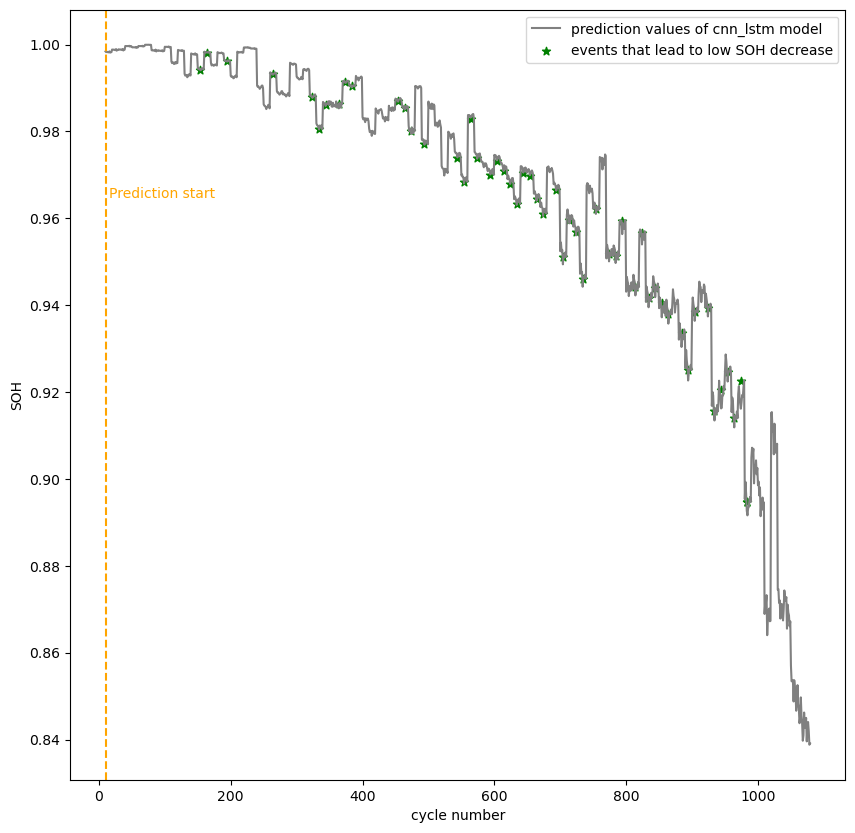

In [45]:
eventsl=get_graph(data[5],frequent_itemsets_low,names1,ic,id,vc,vd,tc,td,"green","low")

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\3947279198.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1["Ic"][i]= (x1["Ic"][i]-min_max[0])/(min_max[1]-min_max[0])
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\3947279198.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1["Id"][i]= (x1["Id"][i]-min_max[2])/(min_max[3]-min_max[2])
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\3947279198.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

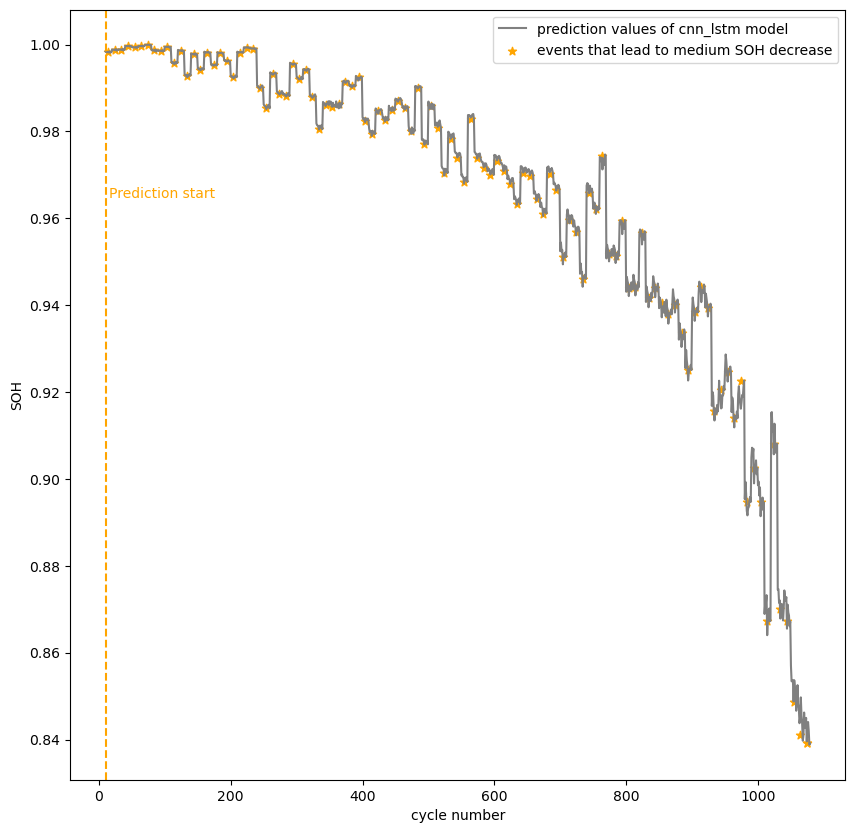

In [46]:
eventsm=get_graph(data[5],frequent_itemsets_midum,names2,ic,id,vc,vd,tc,td,"orange","medium")

C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\3947279198.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1["Ic"][i]= (x1["Ic"][i]-min_max[0])/(min_max[1]-min_max[0])
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\3947279198.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x1["Id"][i]= (x1["Id"][i]-min_max[2])/(min_max[3]-min_max[2])
C:\Users\sarbaoui01\AppData\Local\Temp\ipykernel_13604\3947279198.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing

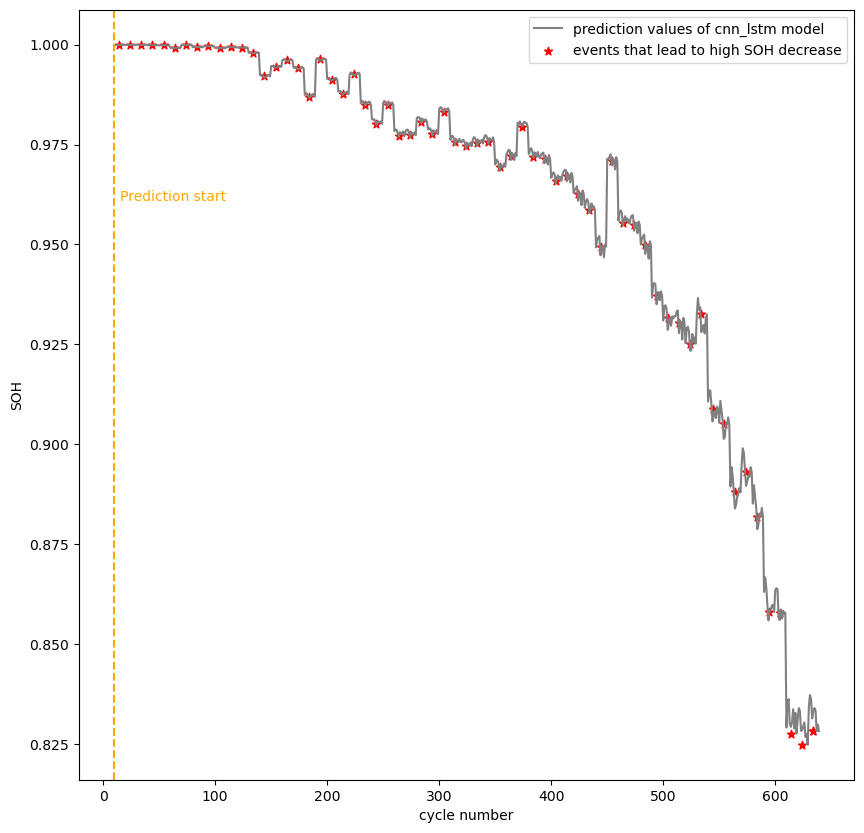

In [48]:
eventsh=get_graph(data[6],frequent_itemsets_high,names3,ic,id,vc,vd,tc,td,"red","high")

In [40]:
def create_chronicle(sequence,ic,id,vc,vd,tc,td,names):
    c=Chronicle()
    ic1=[]
    vc1=[]
    tc1=[]
    id1=[]
    vd1=[]
    td1=[]
    name=[]
    for i in range(len(sequence)):
        position=int(sequence[i][0][1:])
        c.addEvent(Event(sequence[i][0],sequence[i][1]))
        item=names[position]
        name.append(sequence[i][0])
        ic1.append(ic[int(item[0][2:])])
        id1.append(id[int(item[1][2:])])
        vc1.append(vc[int(item[2][2:])])
        vd1.append(vd[int(item[3][2:])])
        tc1.append(tc[int(item[4][2:])])
        td1.append(td[int(item[5][2:])])
    df=pd.DataFrame({"name":name,"ic":ic1,"id":id1,"vc":vc1,"vd":vd1,"tc":tc1,"td":td1})
    
    return c,df

In [41]:
frequent_itemsets_low

[[('E13', 535)],
 [('E13', 539)],
 [('E11', 531)],
 [('E13', 539), ('E13', 540)],
 [('E13', 535), ('E13', 539)],
 [('E13', 539), ('E13', 540), ('E13', 542)],
 [('E11', 531), ('E13', 535)],
 [('E11', 532)],
 [('E11', 536)],
 [('E11', 537)],
 [('E11', 538)],
 [('E13', 530)],
 [('E13', 533)],
 [('E13', 534)],
 [('E13', 535), ('E13', 539), ('E13', 540)],
 [('E13', 537)],
 [('E13', 538)],
 [('E130', 431)],
 [('E15', 47)],
 [('E15', 48)],
 [('E15', 50)],
 [('E15', 51)],
 [('E15', 54)],
 [('E15', 59)],
 [('E15', 60)],
 [('E161', 403)],
 [('E161', 404)],
 [('E161', 405)],
 [('E161', 406)],
 [('E165', 442)],
 [('E165', 443)],
 [('E165', 444)],
 [('E165', 445)],
 [('E168', 426)],
 [('E168', 427)],
 [('E168', 429)],
 [('E168', 430)],
 [('E168', 434)],
 [('E170', 424)],
 [('E170', 425)],
 [('E173', 431)],
 [('E173', 433)],
 [('E173', 435)],
 [('E173', 436)],
 [('E175', 437)],
 [('E179', 419)],
 [('E179', 420)],
 [('E179', 421)],
 [('E181', 419)],
 [('E181', 420)],
 [('E181', 421)],
 [('E181', 422)

In [42]:
frequent_itemsets_low[575]

[('E127', 429), ('E129', 430), ('E130', 431)]

In [43]:
len(names3)

800

In [12]:
chronicle,dff=create_chronicle(frequent_itemsets_low[575],ic,id,vc,vd,tc,td,names1)

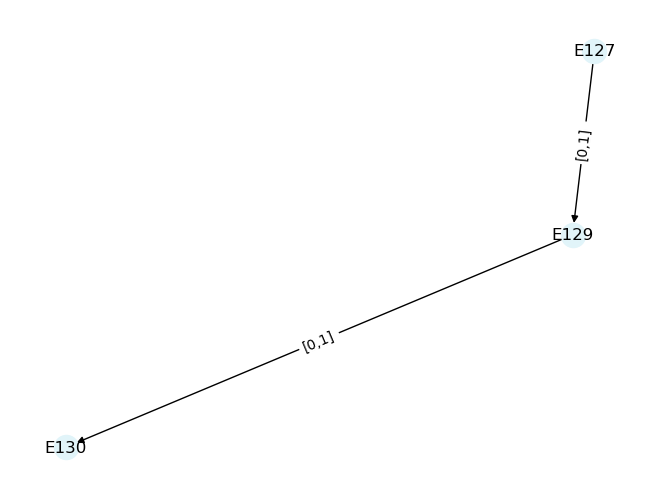

In [13]:
chronicle.plot()

In [14]:
dff

,name,ic,id,vc,vd,tc,td
0,E127,"[[0.23951963636363632, 0.43195810909090904, 0....","[[-0.4799010545454545, -0.8801520909090907, -1...","[[2.0347333, 2.0461078, 2.0651097, 2.0821652, ...","[[3.5882382, 3.5780301, 3.5658851, 3.5556169, ...","[[29.460125, 29.460125, 29.460125, 29.460125, ...","[[30.919823, 30.919823, 30.919823, 30.919823, ..."
1,E129,"[[0.23951963636363632, 0.43195810909090904, 0....","[[-0.4799010545454545, -0.8801520909090907, -1...","[[2.0347333, 2.0461078, 2.0651097, 2.0821652, ...","[[3.5882382, 3.5780301, 3.5658851, 3.5556169, ...","[[30.054186, 30.054186, 30.054186, 30.054186, ...","[[29.6982, 29.6982, 29.6982, 29.6982, 29.6982,..."
2,E130,"[[0.23951963636363632, 0.43195810909090904, 0....","[[-0.4799010545454545, -0.8801520909090907, -1...","[[2.0347333, 2.0461078, 2.0651097, 2.0821652, ...","[[3.5882382, 3.5780301, 3.5658851, 3.5556169, ...","[[29.466322, 29.466322, 29.466322, 29.466322, ...","[[28.575853, 28.575853, 28.575853, 28.575853, ..."


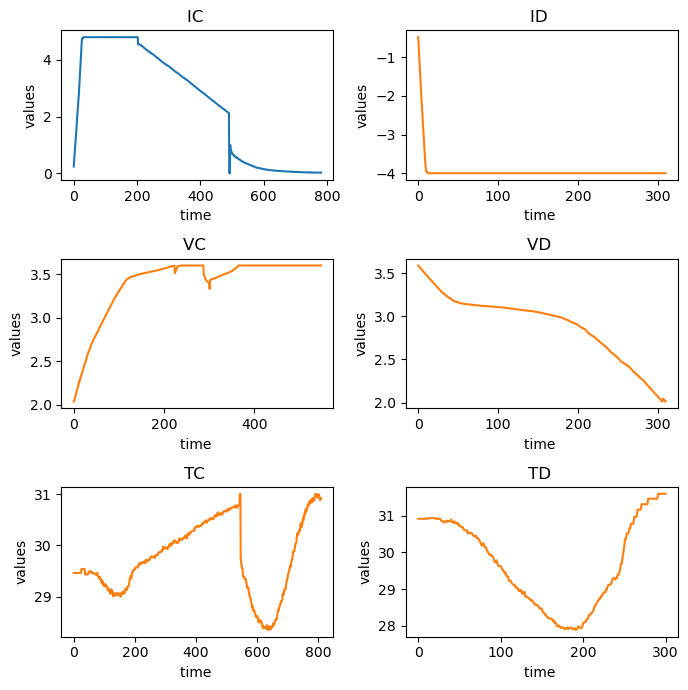

In [16]:
t = np.arange(-20, 20, 4)
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7, 7))
axs[0, 0].set_title("IC ")
axs[0, 0].plot(dff["ic"][0][0], color='C0')
axs[0, 0].set_xlabel("time ")
axs[0, 0].set_ylabel("values")



axs[0, 1].set_title("ID ")
axs[0, 1].plot(dff["id"][0][0], color='C1')
axs[0, 1].set_xlabel("time ")
axs[0, 1].set_ylabel("values")


axs[1, 0].set_title("VC ")
axs[1, 0].plot(dff["vc"][0][0], color='C1')
axs[1, 0].set_xlabel("time ")
axs[1, 0].set_ylabel("values")


axs[1, 1].set_title("VD ")
axs[1, 1].plot(dff["vd"][0][0], color='C1')
axs[1, 1].set_xlabel("time ")
axs[1, 1].set_ylabel("values")

axs[2,0].set_title("TC ")
axs[2,0].plot(dff["tc"][0][0], color='C1')
axs[2,0].set_xlabel("time ")
axs[2,0].set_ylabel("values")


axs[2, 1].set_title("TD ")
axs[2, 1].plot(dff["td"][0][0], color='C1')
axs[2, 1].set_xlabel("time ")
axs[2, 1].set_ylabel("values")


fig.tight_layout()
fig.savefig("events.pdf", format="pdf", dpi=1200)

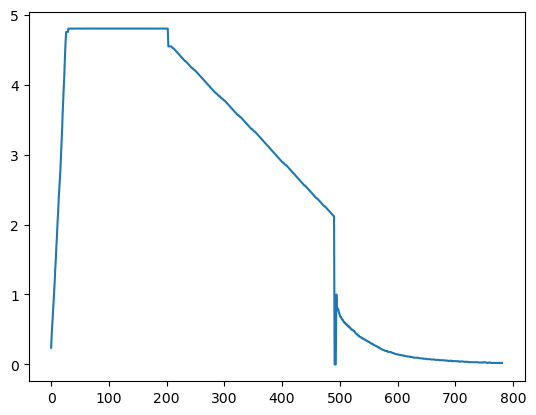

In [156]:
plt.plot(dff["ic"][0][0],label)

In [93]:
np.save("ic",ic)
np.save("id",id)
np.save("vc",vc)
np.save("vd",vd)
np.save("tc",tc)
np.save("td",td)


C:\Users\sarbaoui01\Anaconda3\lib\site-packages\numpy\lib\npyio.py:528: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = np.asanyarray(arr)


In [94]:
np.save("names3",names3)
np.save("names2",names2)
np.save("names1",names1)

In [95]:
np.save("fl",frequent_itemsets_low)
np.save("fm",frequent_itemsets_midum)
np.save("fh",frequent_itemsets_high)

In [7]:
frequent_itemsets_low=np.load("fl.npy",allow_pickle=True)
names1=np.load("names1.npy")

In [4]:
ic=np.load("ic.npy",allow_pickle=True)
id=np.load("id.npy",allow_pickle=True)
vc=np.load("vc.npy",allow_pickle=True)
vd=np.load("vd.npy",allow_pickle=True)
tc=np.load("tc.npy",allow_pickle=True)
td=np.load("td.npy",allow_pickle=True)